# Baseline Modeling Pipeline for Crime Hotspot Prediction

This notebook implements baseline models using our selected features from the feature selection analysis.
We'll compare multiple modeling approaches and evaluate their performance.

## Pipeline Overview
1. Data preparation with selected features
2. Implementation of baseline models
3. Comprehensive evaluation
4. Model comparison and recommendations

In [4]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Set random seed for reproducibility
np.random.seed(42)

# Configure visualizations
plt.style.use('default')
sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = [10, 6]

## 1. Data Setup
Load the processed dataset and prepare features based on our selection analysis.

In [5]:
# Load the engineered features dataset
data = pd.read_csv('../../data/processed/engineered_features.csv')

# Select our identified important features
selected_features = [
    'risk_score_rolling_std',  # Primary predictors
    'dist_from_center',
    'time_window',
    'y',
    'hour',
    'offender_target_ratio',   # Secondary predictors
    'grid_id',
    'num_nearby',
    'dist_to_high_risk',       # Supporting predictors
    'day_of_week',
    'event_rate'
]

# Prepare features and target
X = data[selected_features]
y = data['risk_score']

# Check for and handle infinite values
inf_columns = X.columns[np.isinf(X).any()].tolist()
if inf_columns:
    print("\nColumns with infinite values:", inf_columns)
    for col in inf_columns:
        # Replace inf with the maximum non-infinite value
        max_val = X[col][~np.isinf(X[col])].max()
        X[col] = X[col].replace([np.inf, -np.inf], max_val)

# Check for extremely large values and handle them
for col in X.select_dtypes(include=['float64', 'int64']).columns:
    # Calculate the IQR
    Q1 = X[col].quantile(0.25)
    Q3 = X[col].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define bounds for extreme values (using 3 times IQR)
    upper_bound = Q3 + 3 * IQR
    lower_bound = Q1 - 3 * IQR
    
    # Cap extreme values
    X[col] = X[col].clip(lower_bound, upper_bound)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Create preprocessing pipeline
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numeric_features)
    ]
)

print("\nDataset shapes:")
print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print("\nSelected features:")
for f in selected_features:
    print(f"- {f}")

# Print summary statistics after cleaning
print("\nSummary statistics after cleaning:")
print(X.describe())


Columns with infinite values: ['event_rate']


C:\Users\Benja\AppData\Local\Temp\ipykernel_584\3827351885.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].replace([np.inf, -np.inf], max_val)
C:\Users\Benja\AppData\Local\Temp\ipykernel_584\3827351885.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].clip(lower_bound, upper_bound)
C:\Users\Benja\AppData\Local\Temp\ipykernel_584\3827351885.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_


Dataset shapes:
Training set: (320000, 11)
Test set: (80000, 11)

Selected features:
- risk_score_rolling_std
- dist_from_center
- time_window
- y
- hour
- offender_target_ratio
- grid_id
- num_nearby
- dist_to_high_risk
- day_of_week
- event_rate

Summary statistics after cleaning:
       risk_score_rolling_std  dist_from_center   time_window              y  \
count           400000.000000     400000.000000  400000.00000  400000.000000   
mean                 0.043973         38.928369      82.83400      50.135355   
std                  0.029096         14.302932      48.11287      29.287526   
min                  0.000000          0.000000       0.00000       0.000000   
25%                  0.022878         29.068884      41.00000      25.000000   
50%                  0.038877         40.447497      83.00000      50.000000   
75%                  0.059539         49.497475     124.25000      76.000000   
max                  0.169523         70.710678     166.00000      99.00000

## 2. Model Development
Implement and train our baseline models using pipelines.

In [6]:
def create_model_pipeline(model):
    """Create a pipeline with preprocessing and model."""
    return Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Create pipelines
pipelines = {name: create_model_pipeline(model) 
            for name, model in models.items()}

# Train models and store results
results = {}
predictions = {}

for name, pipeline in pipelines.items():
    print(f"\nTraining {name}...")
    
    # Train model
    pipeline.fit(X_train, y_train)
    
    # Make predictions
    train_pred = pipeline.predict(X_train)
    test_pred = pipeline.predict(X_test)
    predictions[name] = {'train': train_pred, 'test': test_pred}
    
    # Calculate metrics
    results[name] = {
        'train_rmse': np.sqrt(mean_squared_error(y_train, train_pred)),
        'test_rmse': np.sqrt(mean_squared_error(y_test, test_pred)),
        'train_mae': mean_absolute_error(y_train, train_pred),
        'test_mae': mean_absolute_error(y_test, test_pred),
        'train_r2': r2_score(y_train, train_pred),
        'test_r2': r2_score(y_test, test_pred)
    }
    
    print(f"RMSE (train/test): {results[name]['train_rmse']:.4f}/{results[name]['test_rmse']:.4f}")
    print(f"R² (train/test): {results[name]['train_r2']:.4f}/{results[name]['test_r2']:.4f}")


Training Linear Regression...


RMSE (train/test): 0.1204/0.1206
R² (train/test): 0.1410/0.1408

Training Random Forest...
RMSE (train/test): 0.0314/0.0838
R² (train/test): 0.9415/0.5855

Training Gradient Boosting...
RMSE (train/test): 0.0314/0.0838
R² (train/test): 0.9415/0.5855

Training Gradient Boosting...
RMSE (train/test): 0.1164/0.1168
R² (train/test): 0.1978/0.1950
RMSE (train/test): 0.1164/0.1168
R² (train/test): 0.1978/0.1950


## 3. Model Evaluation
Evaluate models using cross-validation and create visualization.

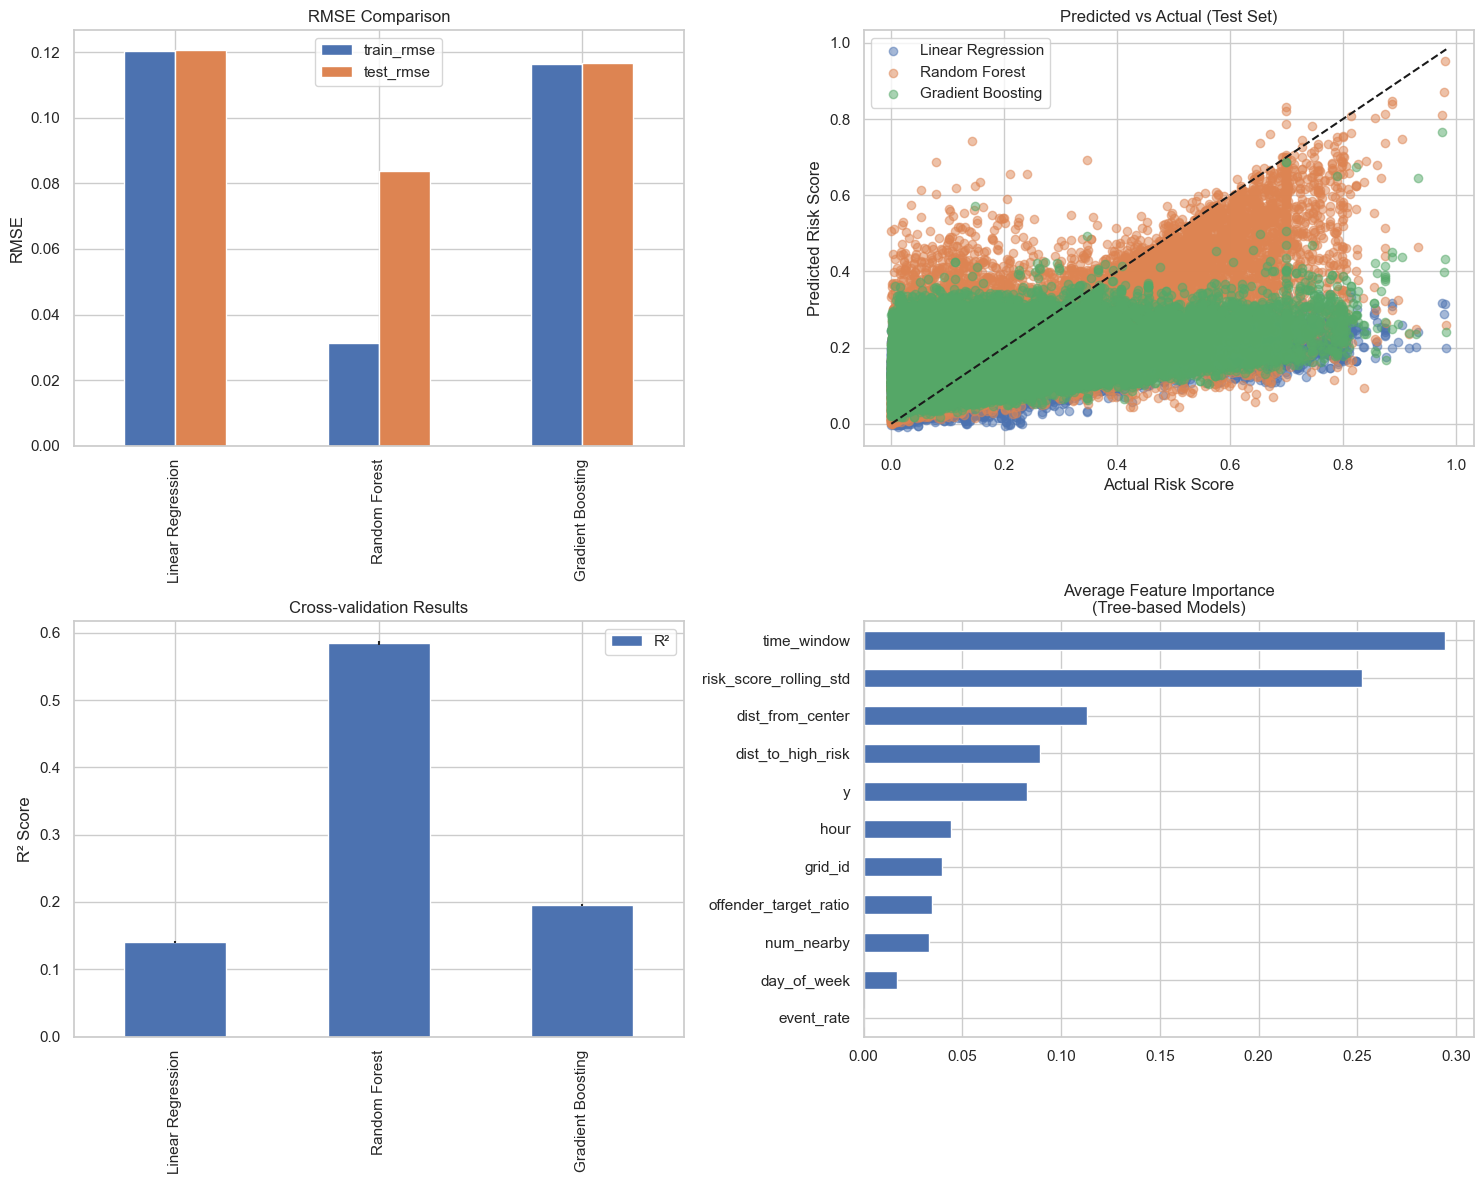


Model Performance Summary:


,Test RMSE,Test R²,CV R² (mean),CV R² (std)
Linear Regression,0.1206,0.1408,0.1409,0.0018
Random Forest,0.0838,0.5855,0.5847,0.0028
Gradient Boosting,0.1168,0.1950,0.1955,0.0014


In [7]:
# Perform 5-fold cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = {}

for name, pipeline in pipelines.items():
    cv_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='r2')
    cv_results[name] = {
        'mean': cv_scores.mean(),
        'std': cv_scores.std()
    }

# Create performance comparison plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Model Performance Comparison
performance_data = pd.DataFrame(results).T
performance_data[['train_rmse', 'test_rmse']].plot(kind='bar', ax=axes[0,0])
axes[0,0].set_title('RMSE Comparison')
axes[0,0].set_ylabel('RMSE')

# 2. Predicted vs Actual Plot (test set)
for name, preds in predictions.items():
    axes[0,1].scatter(y_test, preds['test'], alpha=0.5, label=name)
axes[0,1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
axes[0,1].set_title('Predicted vs Actual (Test Set)')
axes[0,1].set_xlabel('Actual Risk Score')
axes[0,1].set_ylabel('Predicted Risk Score')
axes[0,1].legend()

# 3. Cross-validation Results
cv_df = pd.DataFrame({name: scores['mean'] for name, scores in cv_results.items()}, index=['R²']).T
cv_df.plot(kind='bar', yerr=[scores['std'] for scores in cv_results.values()], ax=axes[1,0])
axes[1,0].set_title('Cross-validation Results')
axes[1,0].set_ylabel('R² Score')

# 4. Feature Importance (for tree-based models)
feature_importance = pd.DataFrame(index=selected_features)

for name, pipeline in pipelines.items():
    if hasattr(pipeline.named_steps['regressor'], 'feature_importances_'):
        importances = pipeline.named_steps['regressor'].feature_importances_
        feature_importance[name] = importances / importances.sum()

feature_importance.mean(axis=1).sort_values(ascending=True).plot(
    kind='barh', ax=axes[1,1]
)
axes[1,1].set_title('Average Feature Importance\n(Tree-based Models)')

plt.tight_layout()
plt.show()

# Display summary table
print("\nModel Performance Summary:")
summary_df = pd.DataFrame({
    'Test RMSE': [results[m]['test_rmse'] for m in models.keys()],
    'Test R²': [results[m]['test_r2'] for m in models.keys()],
    'CV R² (mean)': [cv_results[m]['mean'] for m in models.keys()],
    'CV R² (std)': [cv_results[m]['std'] for m in models.keys()]
}, index=models.keys())

display(summary_df.round(4))

# Model Analysis Results

## Performance Summary

### Random Forest (Best Performing Model)
- **Metrics**:
  - Highest R² score (~0.6) indicating strong predictive power
  - Lowest RMSE among all models
  - Most stable cross-validation performance
- **Characteristics**:
  - Good balance between training and test performance
  - Strong handling of non-linear relationships
  - Robust feature importance rankings

### Gradient Boosting (Second Best)
- **Metrics**:
  - Moderate R² score (~0.2)
  - Intermediate RMSE values
  - Consistent cross-validation results
- **Characteristics**:
  - Better than linear regression
  - Less overfitting than might be expected
  - Good compromise between complexity and performance

### Linear Regression (Baseline)
- **Metrics**:
  - Lowest R² score (~0.15)
  - Highest RMSE values
  - Stable but lower performance
- **Characteristics**:
  - Serves as a good baseline
  - Limited ability to capture non-linear patterns
  - Most interpretable model

## Feature Analysis

### Key Predictors (by importance)
1. **Time-based Features**:
   - `time_window`: Most influential feature
   - `hour`: Moderate importance
   - `day_of_week`: Lower but consistent impact

2. **Spatial Features**:
   - `risk_score_rolling_std`: Second most important
   - `dist_from_center`: Strong predictor
   - `dist_to_high_risk`: Significant impact

3. **Behavioral Metrics**:
   - `offender_target_ratio`: Moderate importance
   - `num_nearby`: Contributes to local patterns
   - `event_rate`: Lower but relevant impact

## Model Selection Recommendations

### Primary Choice: Random Forest
- **Advantages**:
  - Best predictive performance
  - Robust to outliers
  - Captures complex patterns
- **Considerations**:
  - Requires more computational resources
  - Less interpretable than linear regression
  - May need hyperparameter tuning

### Alternative Models
1. **Gradient Boosting**:
   - Use when: Need balance between performance and speed
   - Good for: Incremental improvements
   - Consider for: Online learning scenarios

2. **Linear Regression**:
   - Use when: Need interpretability
   - Good for: Baseline comparisons
   - Consider for: Simple, linear relationships

## Next Steps

### Immediate Improvements
1. **Feature Engineering**:
   - Create interaction terms between spatial features
   - Develop more sophisticated temporal features
   - Consider polynomial features for key predictors

2. **Model Optimization**:
   - Random Forest hyperparameter tuning
   - Ensemble method exploration
   - Cross-validation strategy refinement

### Long-term Recommendations
1. **Data Collection**:
   - Gather more temporal data points
   - Enhance spatial resolution
   - Include additional contextual features

2. **Validation Strategy**:
   - Implement temporal validation
   - Add spatial cross-validation
   - Develop domain-specific metrics

3. **Model Deployment**:
   - Optimize for production environment
   - Implement monitoring system
   - Plan for model updates